# 15. 성과 및 위험평가

백테스트를 통해 포트폴리오 수익률을 구했다면, 이를 바탕으로 각종 성과 및 위험을 평가해야 합니다. 아무리 성과가 좋은 전략이라도 위험이 너무 크다면 투자를 하기 부담스럽습니다. 또한 전략의 수익률이 지속적으로 감소하는 추세라면 경쟁이 치열해져 더 이상 작동하지 않는 전략일 가능성도 있습니다.

이번 장에서는 포트폴리오의 예시로 퀄리티 팩터를 종합적으로 고려한 QMJ(Quality Minus Junk) 팩터(Asness, Frazzini, and Pedersen 2019)의 수익률을 이용하겠습니다. QMJ 팩터란 우량성이 높은 종목들을 매수하고, 우량성이 낮은 종목들을 공매도하는 전략을 지수의 형태로 나타낸 것입니다. 해당 팩터의 수익률을 통해 성과 및 위험을 평가해보고, 회귀분석을 통해 다른 팩터와의 관계도 살펴보겠습니다.

QMJ 팩터의 수익률은 AQR Capital Management의 Datasets[^aqr]에서 엑셀 파일을 다운로드 한 후 가공할 수도 있습니다. 그러나 해당 작업을 매번 하는 것은 지나치게 번거로우므로, 파이썬에서 엑셀 파일을 다운로드한 후 가공하겠습니다.

[^aqr]: https://www.aqr.com/Insights/Datasets/Quality-Minus-Junk-Factors-Monthly

In [2]:
import requests
import pandas as pd

url = "https://images.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Quality-Minus-Junk-Factors-Monthly.xlsx"
resp = requests.get(url)

output = open('data/QMJ.xlsx', 'wb')
output.write(resp.content)
output.close()

In [162]:
xls_QMJ = pd.ExcelFile('data/QMJ.xlsx')
xls_QMJ.sheet_names

['QMJ Factors',
 'Definition',
 'Data Sources',
 '--> Additional Global Factors',
 'MKT',
 'SMB',
 'HML FF',
 'HML Devil',
 'UMD',
 'ME(t-1)',
 'RF',
 'Sources and Definitions',
 'Disclosures']

1. 해당 데이터의 엑셀 url을 저장합니다.
2. `get()` 함수를 통해 페이지의 데이터를 불러옵니다.
3. `open()` 함수를 통해 엑셀 파일을 생성하고, `write()` 함수를 통해 읽어온 엑셀 내용을 저장합니다. 그 후 `close()` 함수를 통해 파일 객체를 닫아줍니다.
4. `ExcelFile()` 함수를 통해 엑셀 파일의 내용들을 불러옵니다.
5. sheet_names을 통해 엑셀의 시트명들을 확인합니다.

우리가 필요한 데이터는 수익률을 계산할 QMJ Factors, 회귀분석에 필요한 MKT, SMB, HML Devil, UMD, 무위험 이자율인 RF 시트의 데이터입니다.

In [163]:
df_QMJ = xls_QMJ.parse(sheet_name = 'QMJ Factors', skiprows = 18)
df_QMJ = df_QMJ.loc[df_QMJ['DATE'].notnull().values, ['DATE', 'Global']]

df_MKT = xls_QMJ.parse(sheet_name = 'MKT', skiprows = 18)
df_MKT = df_MKT.loc[df_MKT['DATE'].notnull().values, ['DATE', 'Global']]


df_SMB = xls_QMJ.parse(sheet_name = 'SMB', skiprows = 18)
df_SMB = df_SMB.loc[df_SMB['DATE'].notnull().values, ['DATE', 'Global']]

df_HML = xls_QMJ.parse(sheet_name = 'HML Devil', skiprows = 18)
df_HML = df_HML.loc[df_HML['DATE'].notnull().values, ['DATE', 'Global']]

df_UMD = xls_QMJ.parse(sheet_name = 'UMD', skiprows = 18)
df_UMD = df_UMD.loc[df_UMD['DATE'].notnull().values, ['DATE', 'Global']]

df_RF = xls_QMJ.parse(sheet_name = 'RF', skiprows = 18)

xls_QMJ에 엑셀 데이터가 불러와 있으므로, `parse()` 함수 내에 원하는 시트명들을 입력합니다. 또한 각 시트 내 18행까지는 데이터를 설명하는 텍스트이므로, skiprows 인자를 통해 해당 부분은 읽어오지 않도록 합니다. DATE가 null이 아닌 행 중에서 날짜에 해당하는 DATE와 수익률에 해당하는 Global 열만을 선택합니다.

In [164]:
from functools import reduce

df_list = [df_QMJ, df_MKT, df_SMB, df_HML, df_UMD, df_RF]
df = reduce(lambda  left, right: pd.merge(left,right,on=['DATE'],
                                          how='inner'), df_list).dropna()
df.columns = ['DATE', 'QMJ', 'MKT', 'SMB', 'HML', 'UMD', 'RF']
df['R_excess'] = df['QMJ'] - df['RF']
df['Mkt_excess'] = df['MKT'] - df['RF']
df = df.set_index('DATE')
df.index = pd.DatetimeIndex(df.index)

1. `merge()` 함수를 통해 DATE 기준으로 데이터를 묶어주어야 합니다. `reduce()` 함수를 통해 모든 데이터를 한번에 묶어주도록 하며, NA 데이터는 제거합니다.
2. 열 이름을 입력합니다.
3. QMJ 팩터 수익률에서 무위험 수익률을 차감해 초과수익률(R_excess)을 구해주며, 시장 수익률에서 무위험 수익률을 차감해 시장위험 프리미엄(Mkt_excess)을 계산해줍니다.
4. DATE를 인덱스로 설정합니다.
5. 인덱스를 DatetimeIndex 형태로 변경해줍니다.

위 과정을 통해 구한 데이터를 바탕으로 성과 및 위험을 평가하겠습니다.

## 15.1 결과 측정 지표

포트폴리오의 평가에서 가장 중요한 지표는 수익률과 위험입니다. 수익률은 누적수익률과 연율화 수익률, 연도별 수익률이 주요 지표이며, 위험은 변동성과 낙폭이 주요 지표입니다. 이 외에도 승률, 롤링 윈도우 값 등 다양한 지표를 살펴보기도 합니다. 

### 15.1.1 수익률 및 변동성

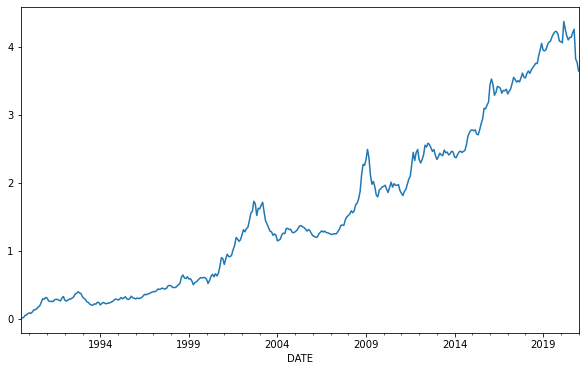

In [16]:
from matplotlib import pyplot as plt
import pandas as pd

ret_cum = df['QMJ'].add(1).cumprod() - 1
ret_cum.plot(figsize=(10, 6))
plt.show()

먼저 QMJ 팩터의 누적수익률을 그래프로 나타내봅니다. 장기간동안 우상향하는 모습을 보이고 있습니다.

In [22]:
df['QMJ'].add(1).prod() - 1 # 누적수익률

3.641751479791373

In [21]:
df['QMJ'].mean() * 12 # 연율화 수익률(산술)

0.05142507725480658

In [20]:
df['QMJ'].add(1).prod() ** (12/len(df)) - 1 # 연율화 수익률(기하)

0.04980505888870268

수익률 중 가장 많이보는 지표는 누적 수익률, 연율화 수익률(산술), 연율화 수익률(기하)입니다. 각 수익률을 구하는 법은 다음과 같습니다.

1. 누적 수익률: $(1+r_1) \times (1+r_2) \times \dots \ \times (1+r_n) - 1 = \{\prod_{i=1}^n(1+r_i)\}-1$
2. 연율화 수익률(산술): $\frac{(r_1 + r_2 + \dots + r_i)}{n} \times scale$
3. 연율화 수익률(기하): $\{\prod_{i=1}^n(1+r_i)\}^{scale / Days} - 1$

먼저 누적수익률은 각 수익률에 1을 더한 값을 모두 곱한 후 1을 빼면 됩니다. 연율화 수익률(산술)은 단순히 수익률의 평균을 구한 후 연율화를 위한 조정값($scale$)을 곱해주면 됩니다. 데이터가 일간일 경우 조정값은 252, 주간일 경우 52, 월간일 경우 12입니다. 현재 데이터는 월간 기준이므로 조정값은 12가 됩니다. 마지막으로 연율화 수익률(기하)은 각 수익률에 1을 더한 값의 곱을 구한 후 연율화를 위해 승수를 적용한 후 1을 빼주며, $Days$는 시계열의 관측 기간입니다.

In [24]:
import math

df['QMJ'].std() * math.sqrt(12) # 연율화 변동성

0.07398877010868485

In [28]:
r = df['R_excess'].add(1).prod() ** (12/len(df)) - 1
v = df['QMJ'].std() * math.sqrt(12) 

print(r/v) # 샤프지수

0.2941252156884136


위험으로 가장 많이 사용되는 지표는 변동성입니다. 연율화 변동성은 `std()` 함수를 통해 변동성을 계산한 후 조정값($\sqrt{Days}$)을 곱해 계산합니다.

샤프 지수(Sharpe Ratio)는 수익을 위험으로 나누어 위험 조정 수익률입니다. 해당 지수는 $\frac {R_i - R_f}{\sigma_i}$로 계산되며, 분자에는 포트폴리오 수익률에서 무위험 수익률을 차감한 값, 분모에는 포트폴리오의 변동성을 사용합니다.

### 15.1.2 낙폭과 최대낙폭

먼저 낙폭(Drawdown)은 수익률이 하락한 후 반등하기 전까지 얼마나 하락했는지를 나타냅니다. 최대낙폭(Maximum Drawdown)은 이러한 낙폭 중 가장 값이 큰 값으로서, 최고점에서 최저점까지 얼마나 손실을 보는지를 나타냅니다. 투자를 함에 있어 수익률이 하락하는 것은 어쩔 수 없지만, 최대낙폭이 지나치게 큰 전략에 투자하는 것은 매우 위험한 선택이 될 수 있습니다.

```{figure} image/drawdown.png
---
name: drawdown
---
낙폭과 최대낙폭
```

낙폭을 계산하는 법은 다음과 같으며, 전고점 대비 하락폭 만을 계산하게 됩니다.

$$ 낙폭 = \frac{현재\ 누적\ 수익률 - 최고\ 누적\ 수익률}{최고\ 누적\ 수익률} = \frac{현재\ 누적\ 수익률}{최고\ 누적\ 수익률}- 1$$

이를 계산하는 방법은 다음과 같습니다.

In [71]:
def drawdown(R) :
    Return_cumulative = R.add(1).cumprod()
    maxCumulativeReturn  = Return_cumulative.cummax()
    dd = Return_cumulative/maxCumulativeReturn - 1
    
    return(dd)

drawdown(df['QMJ'])

DATE
1989-07-31    0.000000
1989-08-31    0.000000
1989-09-30    0.000000
1989-10-31    0.000000
1989-11-30    0.000000
                ...   
2020-09-30   -0.030402
2020-10-31   -0.021389
2020-11-30   -0.102006
2020-12-31   -0.111877
2021-01-31   -0.135515
Name: QMJ, Length: 379, dtype: float64

1. 먼저 누적수익률을 계산합니다.
2. `cummax()` 함수를 통해 누적 최댓값을 계산합니다.
3. 낙폭의 수식에 맞게 둘 간의 차이를 계산합니다.

QMJ 팩터의 초기에는 수익률이 계속해서 최고점을 기록해 낙폭이 0으로 계산되지만, 시간이 지남에 따라 하락을 하게되면 낙폭은 전고점 대비 얼마나 떨어졌는가를 나타냅니다.

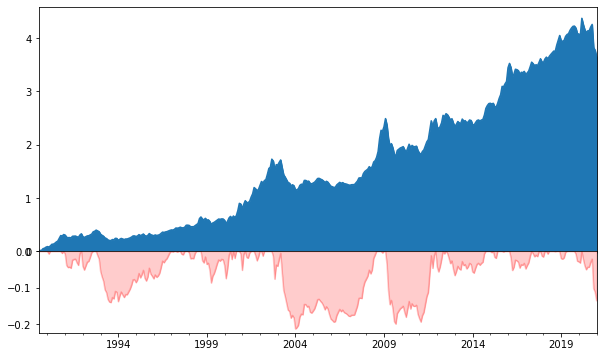

In [67]:
from matplotlib import pyplot as plt
from matplotlib import gridspec

ret_cum = df['QMJ'].add(1).cumprod() - 1
ret_dd = drawdown(df['QMJ'])

fig = plt.subplots(figsize=(10, 6), sharex=True)
gs = gridspec.GridSpec(nrows = 2, ncols = 1, height_ratios=[3, 1])
ax1 = plt.subplot(gs[0])
ax1 = ret_cum.plot.area()
ax1.set_xlabel('')
ax1.axes.xaxis.set_ticks([])

ax2 = plt.subplot(gs[1])
ax2 = ret_dd.plot.area(color = 'r', alpha = 0.2)
ax2.set_xlabel('')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

누적수익률과 낙폭을 함께 그림으로 나타내보면 그 이해가 더 쉽습니다. 수익률이 전고점을 돌파하는 기간에서는 낙폭이 0으로 계산됩니다.

최대낙폭은 낙폭이 가장 심한 경우, 즉 고점에서 투자해 가장 큰 손실을 볼 수 있는 최악의 경우를 나타냅니다. 이를 낙폭에서 `min()` 함수를 통해 계산이 가능합니다.

In [13]:
drawdown(df['QMJ']).min()

-0.2133532229958336

역대 낙폭이 가장 심했던 순서대로 낙폭의 정도, 하락기간과 상승 기간, 원금이 회복되는데 소요된 기간 등을 보는 것도 중요합니다. 아래 코드는 이를 함수 형태로 짠 것입니다.

In [75]:
def tableDrawdown(R, n = 5) :
    
    Return_cumulative = R.add(1).cumprod()
    maxCumulativeReturn  = Return_cumulative.cummax()
    dd = 1 - Return_cumulative/maxCumulativeReturn

    df_bind = pd.concat([R, Return_cumulative, maxCumulativeReturn, dd], axis = 1)
    df_bind.columns = ['Return', 'Cum Ret', 'Max', 'Drawdown']

    groups = df_bind.groupby(df_bind['Max'])
    dd = groups[['Drawdown']].apply(lambda x: x[x['Drawdown'] == x['Drawdown'].max()])
    dd = dd.sort_values('Drawdown', ascending=False).head(n)
    
    def drawdown_table(dd, index_list) :
        group_max, date_max = index_list
        ddGroup = df_bind[df_bind['Max'] == group_max]

        group_start = ddGroup[0:1].index[0]    
        group_end = ddGroup.tail(1).index[0]

        group_length = len(ddGroup)
        group_dd = round(ddGroup['Drawdown'].max(), 4)
        group_dd_length = len(ddGroup[ddGroup.index <= date_max])

        group_rec = group_length - group_dd_length

        return group_start, date_max, group_end, group_dd, group_length, group_dd_length, group_rec
    
    dd_col = ('From','Through','To', 'Depth','Length','Drop','Recovery')
    df_dd = pd.DataFrame(columns = dd_col)

    for i in range(0, n) :
        index_list = dd.iloc[[i], :].index.tolist()[0]
        df_dd.loc[i] = drawdown_table(df,index_list)
        
    return(df_dd)

In [76]:
tableDrawdown(df['QMJ'], n = 5)

,From,Through,To,Depth,Length,Drop,Recovery
0,2002-09-30,2004-01-31,2008-07-31,0.2134,71,17,54
1,2009-02-28,2009-09-30,2012-04-30,0.1998,39,8,31
2,1992-10-31,1993-08-31,1996-12-31,0.1408,51,11,40
3,2020-03-31,2021-01-31,2021-01-31,0.1355,11,11,0
4,1998-09-30,1999-04-30,2000-04-30,0.0869,20,8,12


- From: 하락 시작 시점
- Through: 낙폭 최대 시점
- To: 전고점 회복 시점
- Depth: 낙폭 정도
- Length: 하락 이후 전고점 회복까지 기간
- Drop: 하락 기간
- Recovery: 회복 기간

2002년 9월에 투자할 경우 2004년 1월까지 무려 17개월간 21.34%가 하락한 후, 54개월이 지난 후에야 전고점을 회복하게 됩니다. 즉 원금이 회복하는데 71개월이나 걸리게 됩니다.

In [82]:
r = df['R_excess'].add(1).prod() ** (12/len(df)) - 1
mdd = abs(drawdown(df['QMJ']).min())

r/mdd # 칼마 지수

0.1019996916904431

칼마 지수(Calmar Ratio)는 샤프 지수에서 분자를 최대 낙폭으로 변경한 것으로써, 초과 수익률을 최대낙폭으로 나눈 값입니다. 이는 특히나 안정적인 절대 수익률을 추구하는 헤지펀드에서 많이 참조하는 지표입니다.

### 15.1.3 연도별 수익률

연도별로 수익률을 계산하는 법은 다음과 같습니다.

In [166]:
ret_yr = df['QMJ'].resample('Y').apply(lambda x: (x+1).prod() - 1)
ret_yr.index = ret_yr.index.strftime('%Y')

ret_yr.head()

DATE
1989    0.076947
1990    0.219906
1991    0.010863
1992    0.029826
1993   -0.093064
Name: QMJ, dtype: float64

1. `resample()` 함수를 통해 연도별로 묶어주며, `apply()` 함수를 통해 누적수익률을 계산합니다.
2. `strftime()` 함수를 통해 연도에 해당하는 숫자만 인덱스에 남겨둡니다.

이번에는 연도별 수익률을 그래프로 나타내보도록 하겠습니다.

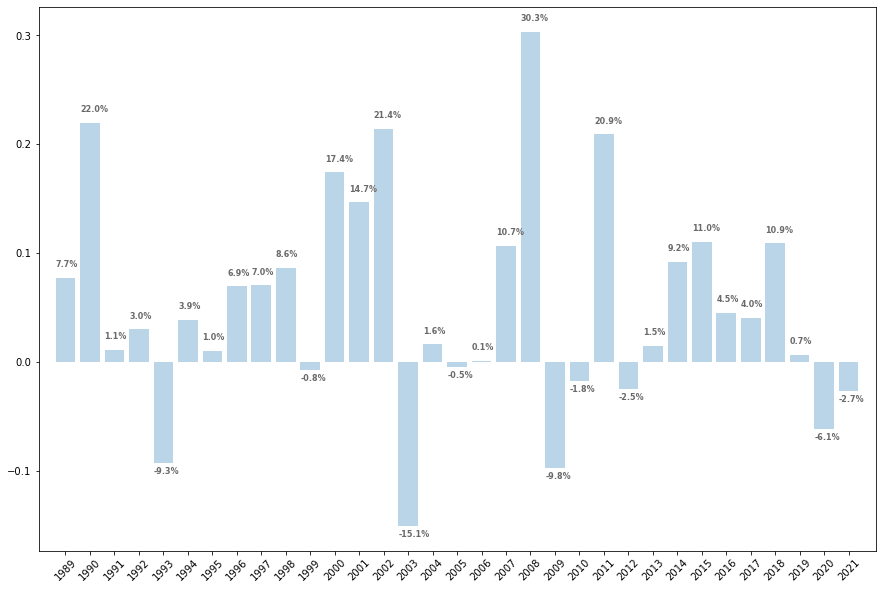

In [269]:
from matplotlib import pyplot as plt

ax = ret_yr.plot.bar(figsize=(15, 10), width = 0.8, alpha = 0.3)
ax.set_xlim(-1.1, len(ret_yr) + 0.1)
plt.xlabel('')
plt.xticks(rotation=45)

totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)

for i in ax.patches:    
    h = 0.01 if i.get_height() > 0 else -0.01
    ax.text(i.get_x(), i.get_height() + h,
            str(round((i.get_height() * 100), 1)) + '%',
                color='dimgrey', size = 8, fontweight="bold")

plt.show()

위에서 계산된 연도별 수익률을 막대 그래프와 텍스트로 나타내면, 포트폴리오의 수익률 추이가 더욱 쉽게 확인됩니다.

### 15.1.4 승률 및 롤링 윈도우 값

승률이란 포트폴리오가 벤치마크 대비 높은 성과를 기록한 비율을 의미하며 다음과 같이 계산됩니다.

$$\frac { 포트폴리오\ 수익률 > 벤치마크인\ 횟수}{전체\ 기간}$$

벤치마크가 S&P 500 지수, KOSPI 200 지수처럼 구체적으로 존재하는 경우도 있지만, 절대수익을 추구하는 경우에는 이러한 벤치마크가 0 혹은 무위험 수익률이 되기도 합니다. 승률을 계산하는 법은 다음과 같습니다.

In [270]:
def UpsideFrequency(R, MAR = 0):
    R = R.dropna()
    ratio = (R > MAR).sum() / len(R)
    return(round(ratio, 4))

UpsideFrequency(df['QMJ'], 0)

0.5884

1. NA 데이터를 제거합니다.
2. 수익률이 벤치마크(MAR) 대비 높았던 횟수를 합한 후, 이를 전체 기간으로 나눠줍니다.

이를 통해 QMJ 팩터의 월간 기준 수익률이 플러스를 기록했던 비율이 계산됩니다.

위에서 구한 각종 지표들은 투자자가 포트폴리오의 시작부터 현재까지 투자를 했다는 전제 하에 계산됩니다. 그러나 투자를 시작하는 시점은 사람마다 다르기에, 무작위 시점에 투자했을 때 향후 n개월 후 승률 혹은 연율화 수익률 등을 계산할 필요도 있습니다. 이러한 기법을 롤링 윈도우라고 합니다.

In [301]:
roll_12 = (df['QMJ']+1).rolling(12).apply(np.prod) ** (12/12) - 1
roll_12_ratio = UpsideFrequency(roll_12, 0)

roll_24 = (df['QMJ']+1).rolling(24).apply(np.prod) ** (12/24) - 1
roll_24_ratio = UpsideFrequency(roll_24, 0)

roll_36 = (df['QMJ']+1).rolling(36).apply(np.prod) ** (12/36) - 1
roll_36_ratio = UpsideFrequency(roll_36, 0)

print("12M:", roll_12_ratio, "\n",
      "24M:", roll_24_ratio, "\n",
      "36M:", roll_36_ratio)

12M: 0.7582 
 24M: 0.7978 
 36M: 0.8779


롤링 윈도우 승률은 무작위 시점에 투자했을 시 미래 n개월 동안의 연율화 수익률을 구하고, 해당 값이 벤치마크 대비 수익이 높았던 비율을 계산합니다. 만일 12개월 롤링 윈도우 승률이 100%라면, 어떠한 시점에 투자해도 12개월 후에는 언제나 벤치마크를 이겼음을 의미합니다. 반면 아무리 연율화 수익률이 높은 전략도 이러한 롤링 윈도우 승률이 지나치게 낮다면, 단순히 한 번의 운으로 인해 수익률이 높은 것처럼 보일수 있습니다.

함수를 이용해 해당 값을 구하는 과정은 다음과 같습니다.

1. 포트폴리오 수익률에 1을 더해준 후 원하는 `rolling()` 내부에 원하는 롤링 기간을 입력합니다. 그 후 롤링 기간에 해당하는 값들을 곱해준 뒤 승수를 취해 연율화를 해준 후, 1을 빼 롤링 연율화 수익률을 계산합니다.
2. 위에서 만든 `UpsideFrequency` 값을 통해 승률을 구합니다.

해당 과정을 통해 12개월, 24개월, 36개월 롤링 승률이 계산되며, 투자 기간이 길어질수록 승률이 높아집니다.

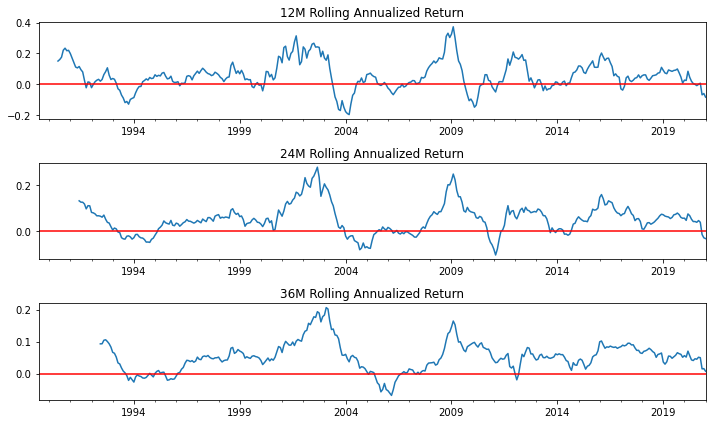

In [307]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

ax1 = plt.subplot(311)
ax1 = roll_12.plot()
ax1.axhline(y = 0, color='r', linestyle='-')
ax1.set_title('12M Rolling Annualized Return')
ax1.set_xlabel('')

ax2 = plt.subplot(312)
ax2 = roll_24.plot()
ax2.axhline(y = 0, color='r', linestyle='-')
ax2.set_title('24M Rolling Annualized Return')
ax2.set_xlabel('')

ax3 = plt.subplot(313)
ax3 = roll_36.plot()
ax3.axhline(y = 0, color='r', linestyle='-')
ax3.set_title('36M Rolling Annualized Return')
ax3.set_xlabel('')

fig.tight_layout() 
plt.show()

롤링 윈도우 연율화 수익률 역시 매우 중요한 지표입니다. 해당 값이 지속적으로 하락할 경우 전략이 더 이상 동작하지 않는 것인지 혹은 가장 험난한 시기를 지났기에 인내심을 갖고 기다려야 할지 판단해야 합니다.

## 15.2 팩터 회귀분석 및 테이블로 나타내기

포트폴리오 수익률에 대한 성과 평가만큼 중요한 것이, 수익률이 어디에서 발생했는가에 대한 요인을 분석하는 것입니다. 베타를 통한 개별 주식과 주식시장과의 관계를 시작으로, 수익률을 설명하기 위한 여러 모형들이 개발되고 발표되었습니다. 그중 일반적으로 많이 사용되는 모형은 기존의 CAPM에 사이즈 팩터(SMB), 밸류 팩터(HML)를 추가한 파마-프렌치의 3팩터 모형(Fama and French 1993), 그리고 3팩터 모형에 모멘텀 팩터(UMD)를 추가한 카하트의 4팩터 모형(Carhart 1997)입니다.

QMJ 팩터를 위 4개 팩터에 회귀분석한 결과를 토대로, 퀄리티 팩터의 수익률에 대한 요인 분석을 해보겠습니다.

In [303]:
import statsmodels.formula.api as smf

reg = smf.ols('R_excess  ~ Mkt_excess  + SMB + HML + UMD', data = df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               R_excess   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     165.4
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           2.26e-81
Time:                        12:32:03   Log-Likelihood:                 1115.0
No. Observations:                 379   AIC:                            -2220.
Df Residuals:                     374   BIC:                            -2200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0025      0.001      3.598      0.000       0.001       0.004
Mkt_excess    -0.2618      0.016    -16.097      0.000      -0.294      -0.230
SMB           -0.3516      0.036     -9.790      0.000      -0.422      -0.281
HML           -0.0979      0.033     -3.004      0.003      -0.162      -0.034
UMD            0.0816      0.026      3.079      0.002       0.029       0.134
==============================================================================
Omnibus:                       17.285   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.883
Skew:                           0.166   Prob(JB):                     3.60e-09
Kurtosis:                       4.534   Cond. No.                         60.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

먼저 우리가 구한 데이터를 통해 다음과 같은 회귀분석을 실시합니다. 즉 QMJ 팩터의 초과수익률을 시장위험 프리미엄, 사이즈 팩터, 밸류 팩터, 모멘텀 팩터에 회귀분석을 수행합니다.

$$QMJ - R_f= \alpha + \beta_m \ [R_m - R_f] + \beta_{SMB} R_{SMB} + \beta_{HML} R_{HML} + \beta_{UMD} R_{UMD}$$

`ols()` 함수 내에서 R_excess는 $QMJ - R_f$와 동일하며, Mkt_excess는 $R_m - R_f$와 동일합니다. 베타의 절댓값이 크다는 의미는 QMJ 팩터의 수익률이 해당 팩터와의 관계가 높다는 의미이며, 양수일 경우에는 양의 관계가, 음수일 경우에는 음의 관계가 높다는 의미입니다. 또한 t값 혹은 P값을 통해 관계가 얼마나 유의한지도 확인할 수 있습니다.

1. 시장 베타에 해당하는 $\beta_m$은 로 음숫값을 보이며, 퀄리티 팩터의 경우 시장과 역의 관계에 있다고 볼 수 있습니다. 또한 t값이 2보다 훨씬 크므로 충분히 유의합니다.
2. 사이즈 베타에 해당하는 $\beta_{SMB}$ 역시 음숫값을 보입니다. 즉 퀄리티 팩터는 소형주보다는 대형주 수익률과 관계가 있으며, t값 역시 충분히 유의합니다.
3. 밸류 베타에 해당하는 $\beta_{HML}$ 역시 음숫값을 보입니다. 즉 퀄리티와 밸류 간의 관계에서 살펴본 것처럼, 두 팩터는 서로 역의 관계가 있습니다. t값 역시 유의합니다.
4. 모멘텀 베타에 해당하는 $\beta_{UMD}$는 양의 관계가 있으며, 모멘텀 팩터가 좋은 시기에 퀄리티 팩터도 좋을 수 있습니다. t값 또한 유의하다고 볼 수 있습니다.
5. 이러한 설명변수를 제외하고도 월간 초과수익률에 해당하는 $\alpha$(Intercept)는 양의 값이며, t값 역시 유의합니다. 즉, 퀄리티 팩터는 기존의 여러 팩터들로 설명되지 않는 새로운 팩터라고도 볼 수 있습니다.


In [96]:
pd.read_html(reg.summary().tables[1].as_html(),header = 0,index_col = 0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0026,0.001,3.654,0.000,0.001,0.004
Mkt_excess,-0.2621,0.016,-16.110,0.000,-0.294,-0.230
SMB,-0.3464,0.036,-9.589,0.000,-0.417,-0.275
HML,-0.0977,0.033,-2.997,0.003,-0.162,-0.034
UMD,0.0814,0.026,3.072,0.002,0.029,0.134


`read_html()` 함수를 사용하면 분석 결과 중 계수에 해당하는 값만을 요약해서 볼 수 있습니다.

In [104]:
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

stargazer = Stargazer([reg])
HTML(stargazer.render_html())

stargazer 패키지를 사용하면, 회귀분석 결과를 논문에서 많이 사용되는 테이블 형식으로 손쉽게 출력할 수 있으며, 이를 그대로 복사해 보고서에 사용할 수 있습니다.